## **Titanic - Machine Learning from Disaster**

In this project, it is necessary to find a model
that predicts which passengers survived the sinking of the Titanic.


### **Introduction**

Importing all of the necessary libraries and inspecting the data.

In [170]:
import joblib
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


# Load the passenger data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# print(df_train.head())
# print(df_test.head())

df_train.info()
df_train.describe().transpose()
shape0 = df_train.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Besides 'Age', only 'Cabin' and 'Embarked' have missing values. We can inspect that further. We can see that 'Cabin','Name','Ticket' columns do not have any meaningful data. Thus, we can remove these columns.

In [171]:
print(df_train.Embarked.value_counts(dropna = False))
print(df_train.Cabin.value_counts(dropna = False))
print(df_train.Ticket.value_counts(dropna = False))

df_train.drop(columns = ['Cabin','Ticket','Name'],inplace = True)

df_train.head()

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64
NaN            687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### **Exploratory Data Analisys**

As a first step, we can check out the correlation between different features. A pair plot is also a good place to start.

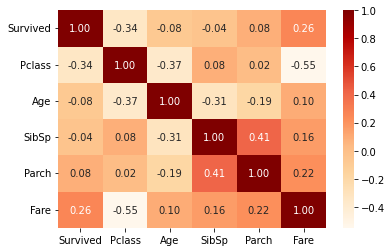

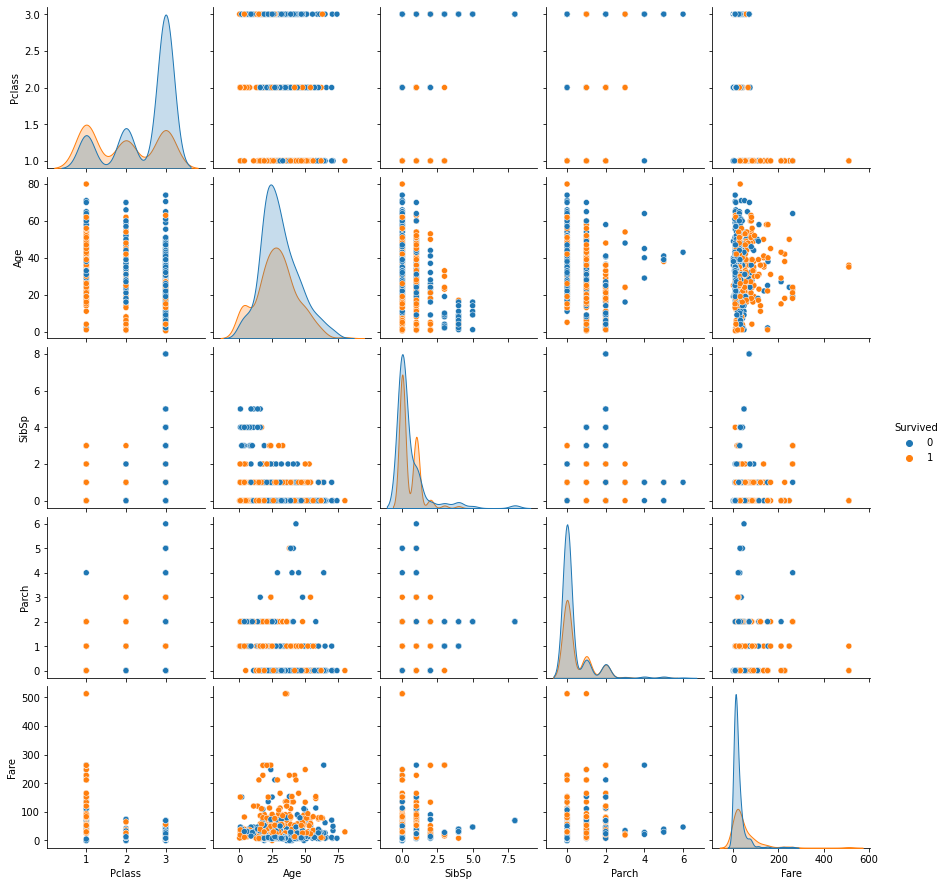

In [172]:
# correlation matrix
sns.heatmap(df_train.drop(columns = ['PassengerId'],axis = 1).corr(),cmap='OrRd',annot=True,fmt=".2f")
plt.show()

# pair plot
sns.pairplot(df_train.drop(columns = ['PassengerId'],axis = 1),hue = 'Survived')
plt.show()

We can see (from the correlation matrix) that only class and fare are related to survival and to each other. We would expect the age to be correlated to survival as well. On the pair plot we can see that young people have a higher survival rate. Also, it can be seen that the majority of the 3rd class died and the majority of the people traveling in the 1st class survived.

We can further inspect the categorical features of the data and their survival status.

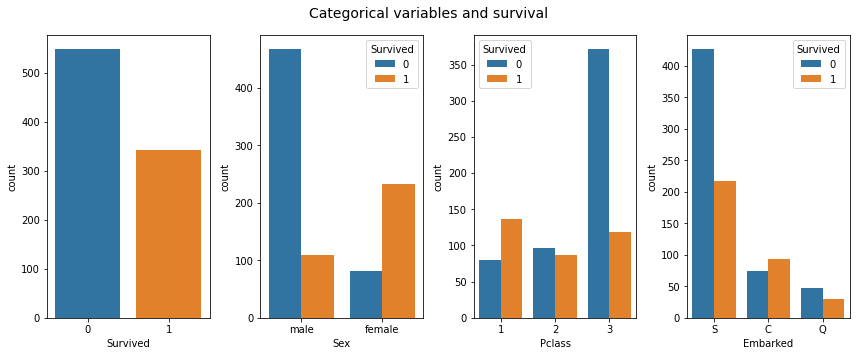

In [173]:
fig,axes=plt.subplots(1,4,figsize=(12,5))
sns.countplot(x="Survived",data=df_train,ax=axes[0])
sns.countplot(x="Sex",hue="Survived",data=df_train,ax=axes[1])
sns.countplot(x="Pclass",hue="Survived",data=df_train,ax=axes[2])
sns.countplot(x="Embarked",hue="Survived",data=df_train,ax=axes[3])
plt.suptitle("Categorical variables and survival",fontsize=14)
plt.tight_layout()

# (Not Finished)

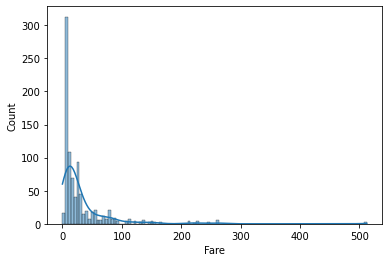

In [174]:
sns.histplot(data = df_train, x = 'Fare',kde = True)
plt.show()

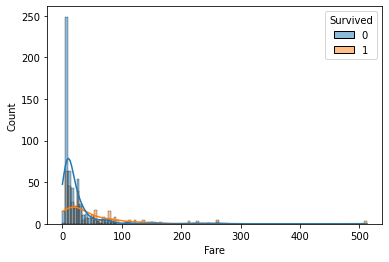

In [175]:
sns.histplot(data = df_train, x = 'Fare', hue = 'Survived', kde = True)
plt.show()

#### Use missing data imputer

### **Data Preprocessing**

Next, 'Sex' column is mapped to integers 0 and 1 and missing values in the 'Age' column are filled with the mean value.

In [176]:
# Update sex column to numerical
df_train.Sex.replace(['female','male'],[1,0],inplace = True)

# Fill the nan values in the age and embarked column
df_train.Age.fillna(df_train.Age.mean(),inplace = True)
df_train.Embarked.fillna(df_train.Embarked.mode()[0],inplace = True) # fill embarked considering ticket/fare or other features!!

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    int64  
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 62.8+ KB


#### Create new features

Now, new features can be created in order to check the contribution of the new features to the model. New column, that has the count of people that were together on the boat, is added. Also, 'Pclass' and 'Embarked' are split into three different columns.

In [177]:
# Family members analysis
df_train['Family'] = df_train['SibSp'] + df_train['SibSp']

N_family_count = df_train.groupby("Family").size()
N_family_survived_mean = (df_train.groupby("Family").Survived.mean())*100

pd.concat([N_family_count,N_family_survived_mean],keys=["Count","SurvivalPerc"],axis=1)

# group fare and age similarily

,Count,SurvivalPerc
Family,,
0,608,34.539474
2,209,53.588517
4,28,46.428571
6,16,25.000000
8,18,16.666667
10,5,0.000000
16,7,0.000000


In [178]:
# Create different class columns
df_train[['FirstClass','SecondClass','ThirdClass']] = pd.get_dummies(df_train.Pclass)

# Create different embarked columns
df_train[['Embarked_C','Embarked_Q','Embarked_S']] = pd.get_dummies(df_train.Embarked)

# drop old columns
df_train.drop(columns = ['Embarked','Pclass','SibSp','Parch'],inplace = True)

df_train.head()

,PassengerId,Survived,Sex,Age,Fare,Family,FirstClass,SecondClass,ThirdClass,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,22.0,7.2500,2,0,0,1,0,0,1
1,2,1,1,38.0,71.2833,2,1,0,0,1,0,0
2,3,1,1,26.0,7.9250,0,0,0,1,0,0,1
3,4,1,1,35.0,53.1000,2,1,0,0,0,0,1
4,5,0,0,35.0,8.0500,0,0,0,1,0,0,1


#### Select features, split and standardize data

In [179]:
# Select the desired features
chosen_features = ['Sex','FirstClass','SecondClass','ThirdClass',\
                    'Family',\
                    # 'Parch',\
                    'Embarked_C',\
                    # 'Embarked_Q',\
                    # 'Embarked_S',\
                    'Age']
                    
features = df_train[chosen_features]

survival = df_train.Survived

# Perform train and test split
X_train, X_test ,y_train, y_test = train_test_split(features,survival, test_size = 0.2)

# # Scale the feature data so it has mean = 0 and standard deviation = 1
# stdScaler = StandardScaler()
# X_train_std = stdScaler.fit_transform(X_train)
# X_test_std = stdScaler.transform(X_test)
  
# number of observations after deleting missig data
print(f'Initial number of observations: {shape0}')
print(f'Number of observations after deleting missing data: {X_train.shape}')


Initial number of observations: (891, 12)
Number of observations after deleting missing data: (712, 7)


### **Machine Learning Models**

We can test various models and compare the results for the same set of data.

#### Logistic Regression

In [180]:
# Create and train the model
LRmodel = LogisticRegression() 

# make pipeline to scale each fold of the data
LRclf = Pipeline(steps = [('standardize',StandardScaler()),( 'model',LRmodel)])

# Kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(LRclf, X_train, y_train, cv=kfold, scoring='accuracy')

print('KFold results:',results)
print("Average: %.2f%%" % (results.mean()*100))
print()

# fit model
LRclf.fit(X_train,y_train)

# Analyze the coefficients
print('Coefficients:')
print(list(zip(features,LRclf['model'].coef_[0])))
print()

# Score the model on the test data
LRclf_score = LRclf.score(X_test,y_test)
print(f'Logistic Regression model score (validation data): {LRclf_score:.4f}')

KFold results: [0.8041958  0.81118881 0.76760563 0.78169014 0.77464789]
Average: 78.79%

Coefficients:
[('Sex', 1.2256581642481104), ('FirstClass', 0.45193122750642567), ('SecondClass', 0.08946265098409964), ('ThirdClass', -0.4648285533688308), ('Family', -0.27210673910071287), ('Embarked_C', 0.21885133448319716), ('Age', -0.36687824863267227)]

Logistic Regression model score (validation data): 0.8212


#### K-Neighbors Classifier


In [181]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
leaf_size = list(range(20,40))

param_grid = dict(model__n_neighbors=k_range, model__weights=weight_options, model__leaf_size = leaf_size)

pipe = Pipeline(steps=[('standardize', StandardScaler()),('model',KNeighborsClassifier())])

KNclf = RandomizedSearchCV(pipe, param_grid, scoring='accuracy', n_iter=30)

# fit the model
KNclf.fit(X_train, y_train)

print("Best parameters set found on validation set:")
print()
print(KNclf.best_params_,f'score: {KNclf.best_score_}')
print()

# get the score
KNclf_score = KNclf.score(X_test,y_test)
print(f'K-Neighbors model score (validation data): {KNclf_score:.4f}')

Best parameters set found on validation set:

{'model__weights': 'distance', 'model__n_neighbors': 9, 'model__leaf_size': 34} score: 0.7991037131882202

K-Neighbors model score (validation data): 0.8212


#### Naive Bayes Classifier

In [182]:
# create and fit Naive Bayes Classifier
MNBclf = MultinomialNB()


# Kfold cross validation
kfold = KFold(n_splits=5, shuffle=True)
results = cross_val_score(MNBclf, X_train.values, y_train.values, cv=kfold, scoring='accuracy')
print('KFold results:',results)
print("Average: %.2f%%" % (results.mean()*100))

# see the accuracy
print()
MNBclf.fit(X_train.values,y_train.values)
MNBclf_score = MNBclf.score(X_test.values,y_test.values)
print(f'Naive Bayes model score (validation data): {MNBclf_score:.4f}')


KFold results: [0.76923077 0.8041958  0.77464789 0.77464789 0.74647887]
Average: 77.38%

Naive Bayes model score (validation data): 0.8212


#### SVM

In [183]:
start_new = True

if start_new:
  files = glob.glob('./models/*')
  for f in files:
    os.remove(f)

#load your model for further usage
try:
  joblib.load("SVCclf.pkl")
except FileNotFoundError:
  # check for the best parameters
  C_range = np.arange(0.1,2,0.2) # after few iterations [0.01,0.1,1,2,3,4, 10,50, 100, 1000]
  gamma_range = np.arange(0.1,2,0.2) # [0.001,1,2,3,4,5,100,1000]
  parameters = [
    {'model__C': C_range,
     'model__gamma': gamma_range
     },
  ]

  # define pipeline for the grid search
  pipe = Pipeline(steps=[('standardize', StandardScaler()),('model',SVC(kernel = 'rbf'))])
  SVCclf = GridSearchCV(pipe, parameters, scoring ='accuracy')

  # find the estimator with best parameters and training data
  SVCclf.fit(X_train, y_train)
  

print("Best parameters set found on validation set:")
print()
print(SVCclf.best_params_,f'score: {SVCclf.best_score_}')
print()
# print("Grid scores on development set:")
# print()
# means = SVCclf.cv_results_["mean_test_score"]
# stds = SVCclf.cv_results_["std_test_score"]
# for mean, std, params in zip(means, stds, SVCclf.cv_results_["params"]):
#   print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# see the score
SVCclf_score = SVCclf.score(X_test,y_test)
print(f'SVC model score (validation data): {SVCclf_score:.4f}')

#save your model or results
joblib.dump(SVCclf, './models/SVCclf.pkl')



Best parameters set found on validation set:

{'model__C': 1.5000000000000004, 'model__gamma': 0.5000000000000001} score: 0.7949177582980399

SVC model score (validation data): 0.8771


['./models/SVCclf.pkl']

#### Decision tree


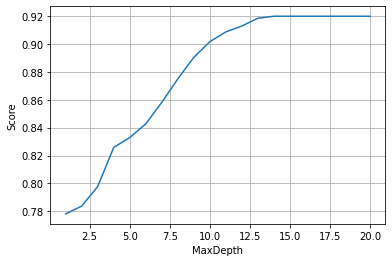

Decision tree model score (validation data): 0.8101


In [184]:
# choose the best depth of the tree
score = []
maxDepth = 21
for i in range(1,maxDepth):

  # create and fit decision tree
  DTclf = DecisionTreeClassifier(max_depth = i)

  DTclf.fit(X_train,y_train)
  score.append(DTclf.score(X_train,y_train))
  # print(score)

# plot results
plt.plot(range(1,maxDepth),score)
plt.xlabel('MaxDepth')
plt.ylabel('Score')
plt.grid()
plt.show()

# train again with the best depth
bestDepth = 14
DTclf = DecisionTreeClassifier(max_depth = bestDepth)
DTclf.fit(X_train,y_train)

# see the score
DTclf_score = DTclf.score(X_test,y_test)
print(f'Decision tree model score (validation data): {DTclf_score:.4f}')


#### Random Forest Classifier


In [185]:
# create and fit random forest
RFclf = RandomForestClassifier(n_estimators = 200)
RFclf.fit(X_train,y_train)

# print feature importance and score
print(list(zip(features.columns,RFclf.feature_importances_)))
print()

# get the score
RFclf_score = RFclf.score(X_test,y_test)
print(f'Random forest model score (validation data): {RFclf_score:.4f}')


[('Sex', 0.31189336204935125), ('FirstClass', 0.04599670313158877), ('SecondClass', 0.020476595245717592), ('ThirdClass', 0.0733894407599774), ('Family', 0.07082155677777353), ('Embarked_C', 0.028945419544442616), ('Age', 0.44847692249114884)]

Random forest model score (validation data): 0.8324


#### XGBoost


#### Cross Validation

In [186]:
#stratifiedkfold

### **Submission**

Now, the best model has to be chosen...

In [187]:
print('Model accuracy results')
print()
print('LR:  %.2f%%' % (LRclf_score*100))
print('KNN:  %.2f%%' % (KNclf_score*100))
print('MNB:  %.2f%%' % (MNBclf_score*100))
print('SVC:  %.2f%%' % (SVCclf_score*100))
print('DT: %.2f%%' % (DTclf_score*100))
print('RF: %.2f%%' % (RFclf_score*100))
print()

models_list = [LRclf,KNclf,MNBclf,SVCclf,DTclf,RFclf]
models_names_list =  ['LR','KNN','MNB','SVC','DT','RF']
model_scores_list = [LRclf_score,KNclf_score,MNBclf_score,SVCclf_score,DTclf_score,RFclf_score]

final_model = models_list[np.argmax(model_scores_list)]
print(f'Best model is {models_names_list[np.argmax(model_scores_list)]} with the accuracy of {max(model_scores_list):.4f}')

Model accuracy results

LR:  82.12%
KNN:  82.12%
MNB:  82.12%
SVC:  87.71%
DT: 81.01%
RF: 83.24%

Best model is SVC with the accuracy of 0.8771


### Prepare test data

Test data has to be prepared in the same manner as the train data.

In [188]:
print(df_test.info())
df_test.drop(columns = ['Cabin','Ticket','Name'],inplace = True)
df_test.Sex.replace(['female','male'],[1,0],inplace = True)
df_test.Age.fillna(df_train.Age.mean(),inplace = True)
df_test.Fare.fillna(df_train.Fare.mean(),inplace = True)

df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,0,34.5,0,0,7.8292,Q
1,893,3,1,47.0,1,0,7.0000,S
2,894,2,0,62.0,0,0,9.6875,Q
3,895,3,0,27.0,0,0,8.6625,S
4,896,3,1,22.0,1,1,12.2875,S


In [189]:
# With how many family members
df_test['Family'] = df_test['SibSp'] + df_test['SibSp']

# Create different class columns
df_test[['FirstClass','SecondClass','ThirdClass']] = pd.get_dummies(df_test.Pclass)

# Create different embarked columns
df_test[['Embarked_C','Embarked_Q','Embarked_S']] = pd.get_dummies(df_test.Embarked)

# drop old columns
df_test.drop(columns = ['Embarked','Pclass'],inplace = True)

df_test.head()

,PassengerId,Sex,Age,SibSp,Parch,Fare,Family,FirstClass,SecondClass,ThirdClass,Embarked_C,Embarked_Q,Embarked_S
0,892,0,34.5,0,0,7.8292,0,0,0,1,0,1,0
1,893,1,47.0,1,0,7.0000,2,0,0,1,0,0,1
2,894,0,62.0,0,0,9.6875,0,0,1,0,0,1,0
3,895,0,27.0,0,0,8.6625,0,0,0,1,0,0,1
4,896,1,22.0,1,1,12.2875,2,0,0,1,0,0,1


Now, we can get the predictions and compose the submission file.

In [190]:
# Select the desired features
test_features = df_test[chosen_features]

# get the predictions
survived = final_model.predict(test_features)
submission = pd.concat([df_test['PassengerId'],pd.Series(survived,name = 'Survived')],axis = 1)

# save submission
submission.to_csv('./submission.csv' ,index = False)
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
